# Case Técnico Fácil Espaider: Classificação Multilabel de gêneros de filmes baseado em sinopse

## Planejamento da Solução

### Entrada

* Base de metadados de filmes com as característica de cada um dos filmes e seus respectivos gêneros atribuídos.
* Sinopse dos filmes com identificador usado para se referenciar a base de metadados dos filmes.
                                                

### Saída

* Qual formato de entrega da solução?

    * 1 Jupyter Notebooks, onde o projeto foi desenvolvido por meio de ciclos, com objetivo de gerenciar e planejar os próximos passos.
    * 2 O modelo está em produção através de uma API criada e hospedada no WebService do Render. As previsões geradas por esse modelo podem ser acessadas por meio de um BOT no Telegram (https://t.me/genrespred_bot). Para utilizar o BOT, basta inserir a sinopse de um filme como entrada e, em seguida, será realizada uma consulta à API do modelo para retornar os gêneros correspondentes à sinopse digitada.

<font size ="2" > PS: *É importante observar que o Telegram tem um limite máximo de 4096 caracteres para cada mensagem enviada. Se a sinopse de um filme ultrapassar esse limite, ela será dividida em duas ou mais mensagens. Nesse caso, o modelo fará uma nova previsão para cada uma dessas partes da mensagem. Portanto, caso queira testar uma sinopse com tamanho maior que 4096 caracteres, estarei disponibilizando uma função ao fim do código para esse teste.* </font>


    


Metodologia
* CRISP-DS, metodologia ágil para desenvolvimento de projetos de ciência de dados (método cíclico).
* Abordagem Classificação MultiLabel utilizando NLP


Ferraments Utilizadas
* Python 3.10.6, Jupyter-Lab, Poetry, Git, Github, Render, Flask API.

## Implementações realizadas na Sprint

### Ciclo 2

* Análise exploratória de dados mais abrangente (sinopse)
* Implementação de funções de pré-processamento e limpeza dos dados, como stopwords, caracteres especiais, acentuados, remoção de espaços, entre outros
* Teste em diferentes parâmetros de criação de features (TFIDF Vectorizer)
* Modularização de código
* Definição de outras métricas e novos parâmetros para testagem de modelos
* Implementação de uma função para predição do modelo baseline, na qual solicitamos uma entrada (sinopse) e é retornado o gênero do filme.




# 0.0 Imports and Helper Functions

In [1]:
import pandas as pd
import csv
from tqdm import tqdm
import json
import nltk 
import re

from matplotlib import pyplot as plt
from IPython.core.display import HTML
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import unicodedata

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

from sklearn.model_selection import KFold

from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.metrics import accuracy_score, precision_score,recall_score,f1_score,hamming_loss,jaccard_score


In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.multiclass import OneVsRestClassifier

## 0.1 Auxiliar Functions

In [3]:
def jupyter_settings():
    %matplotlib inline
    #%pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25,12]
    plt.rcParams['font.size'] = 24
    
    display(HTML ('<style>.container {width:100% !important;} </style>') )
    pd.options.display.max_columns=None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr',False)
    pd.set_option('display.float_format', lambda x: '%.4f' % x)
    
    sns.set()
    
jupyter_settings()

# Contraction to Full Word
def cont_to_exp(x):
    if type(x) is str:
        for key in contractions:
            value=contractions[key]
            x=x.replace(key,value)
        return x
    else:
        return x
    
def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x]) 
    all_words = all_words.split()
    fdist = nltk.FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
    
    # selecting top 20 most frequent words 
    d = words_df.nlargest(columns="count", n = terms) 

    # visualize words and frequencies
    plt.figure(figsize=(12,15)) 
    ax = sns.barplot(data=d, x= "count", y = "word") 
    ax.set(ylabel = 'Word') 
    plt.show()
    
    
def remove_accented_chars(x):
    x = unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return x

def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)


def multilabel_metrics(model,y_true,y_pred):
    
    accuracy = accuracy_score(y_true,y_pred)
    precision = precision_score(y_true,y_pred,average='weighted',zero_division=1)
    recall = recall_score(y_true,y_pred,average='weighted',zero_division=1)
    f1 = f1_score(y_true,y_pred,average='weighted',zero_division=1)
    hamming = hamming_loss(y_true,y_pred)
    jaccard = jaccard_score(y_true,y_pred,average='weighted',zero_division=1)
    
    return pd.DataFrame({'Model Name': type(model).__name__,
                         'accuracy': accuracy,
                         'precision': precision,
                         'recall': recall,
                         'f1_score': f1,
                         'hamming_loss': hamming,
                         'jaccard_score': jaccard},index=[0])


def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)


def clean_text(text):
    
    # lower case
    text = text.lower()
    
    # Remove Contraction and transform into full word
    text = cont_to_exp(text)
    
    # Remove Special Chars or punctuation
    text = re.sub('[^A-Z a-z 0-9-]+', '',text)
    
    # Removed Accented Chars
    text = remove_accented_chars(text)
    
    # Remove Stopwords
    text = remove_stopwords(text)
    
    # Remove all non alphabeticall
    text = re.sub('[^a-zA-Z]',' ',text)
    
    # Removed duplicated spaces
    text = " ".join(text.split())

    return text

def predict_genres(model,text):
    text = clean_text(text)
    text_vec = tfidf.transform([text])
    text_pred = model.predict(text_vec)
    
    return multilabel.inverse_transform(text_pred)


# 1.0 Data Description

## 1.1 Leitura Dados dos Filmes

In [4]:
df1 = pd.read_csv("../data/movie.metadata.tsv", sep = '\t', header = None)
df1.head()

,0,1,2,3,4,5,6,7,8
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0000,98.0000,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0000,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0000,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0000,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0000,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


### 1.1.1 Rename Columns

Dataset without column identification, so let's name the ones that interest us

In [5]:
df1.columns = ['id_filme','col_2', 'nome_filme', 'cod_3', 'cod_4', 'cod_5', 'cod_6','cod_7','genero_filme']
df1.head()

,id_filme,col_2,nome_filme,cod_3,cod_4,cod_5,cod_6,cod_7,genero_filme
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0000,98.0000,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0000,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0000,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0000,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0000,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


## 1.2 Leitura Dados de Entrada ( Sinopses dos Filmes em formato txt)

In [6]:
sinopse = []

with open("../data/plot_summaries.txt", 'r') as file:
    texto = csv.reader(file,dialect='excel-tab')
    
    for row in tqdm(texto):
        sinopse.append(row)

42303it [00:00, 75326.18it/s]


So let's take a look at how the synopses are organized.

In [7]:
sinopse[:2]

[['23890098',
  "Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all."],
 ['31186339',
  'The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl  between the ages of 12 and 18 selected by lottery  for the annual Hunger Games. The tributes must fight to the death in an arena; the sole survivor is rewarded with fame and wealth. In her first Reaping, 12-year-old Primrose Everdeen is chosen from District 12. Her older sister Katniss volunteers to take her place. Peeta Mellark, a baker\'s son who once gave Katniss bread when she was starving, is the other District 12 tribute. Katniss and Peeta are taken to the Capitol, accompanied by their frequently drunk mentor, past victor Haymitch Abernathy. He warns them about the "Career" tributes who train intensively at speci

Here, we have the movie ID and synopsis, which we will use the ID as a reference to the movie dataset and its corresponding genre.

Next step:
* Extract the ID and synopsis from each element in the list and add them to a DataFrame.

In [8]:
id_filme = []
sinopse_filme = []

In [9]:
for i in tqdm(sinopse):
    id_filme.append(i[0])
    sinopse_filme.append(i[1])
    
# Montar o DataFrame 

df_sinopse = pd.DataFrame({'id_filme':id_filme, 'sinopse_filme': sinopse_filme})
df_sinopse.head()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42303/42303 [00:00<00:00, 2334442.57it/s]


,id_filme,sinopse_filme
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


Check duplicated on both dataframes

In [10]:
df1.duplicated().sum()

0

In [11]:
df_sinopse.duplicated().sum()

0

## 1.3 Data Types

In [12]:
df1.dtypes

id_filme          int64
col_2            object
nome_filme       object
cod_3            object
cod_4           float64
cod_5           float64
cod_6            object
cod_7            object
genero_filme     object
dtype: object

In [13]:
df_sinopse.dtypes

id_filme         object
sinopse_filme    object
dtype: object

We will change the movie id to string, so we can join both dataframes

In [14]:
df1['id_filme'] = df1['id_filme'].astype(str)

## 1.4 Data Dimension

In [15]:
df1.shape

(81741, 9)

In [16]:
df_sinopse.shape

(42303, 2)

In [17]:
print('So we have in your metadata of movies: {} with {} columns.'.format(df1.shape[0],df1.shape[1]))
print('In the sinopses dataframe we have only {} films with sinopses defined'.format(df_sinopse.shape[0]))

So we have in your metadata of movies: 81741 with 9 columns.
In the sinopses dataframe we have only 42303 films with sinopses defined


Quick Check in duplicated id_filme and nome_filme

In [18]:
df1[['id_filme']].duplicated().sum()

0

In [19]:
x = df1[df1['nome_filme'].duplicated()]

In [20]:
x.sample(10)

,id_filme,col_2,nome_filme,cod_3,cod_4,cod_5,cod_6,cod_7,genero_filme
34724,36459873,/m/0k8s6n5,Dirty Laundry,2012-07-15,NaN,10.0000,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/0lsxr"": ""Crime..."
33814,2976044,/m/08h5jf,The Hunchback of Notre Dame,1956-12-19,2250000.0000,110.0000,"{""/m/064_8sq"": ""French Language""}","{""/m/0f8l9c"": ""France"", ""/m/03rjj"": ""Italy""}","{""/m/04xvh5"": ""Costume drama"", ""/m/07s9rl0"": ""..."
48184,34551413,/m/0j27lmg,Men,1918-05-15,NaN,NaN,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06ppq"": ""Silent film"", ""/m/07s9rl0"": ""Dra..."
19545,28006483,/m/0c3wrkk,Dhanwan,1981-06-29,NaN,NaN,"{""/m/03k50"": ""Hindi Language""}","{""/m/03rk0"": ""India""}","{""/m/01chg"": ""Bollywood""}"
80178,12336807,/m/02v_r7d,Luther,2003-05-18,29413900.0000,123.0000,"{""/m/04h9h"": ""Latin Language"", ""/m/02h40lc"": ""...","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/04p5fxn"": ""Christian film"", ""/m/017fp"": ""..."
22185,19609453,/m/05b2vs4,Amar Deep,1979,NaN,NaN,"{""/m/03k50"": ""Hindi Language""}","{""/m/03rk0"": ""India""}","{""/m/02l7c8"": ""Romance Film"", ""/m/07s9rl0"": ""D..."
52269,6811111,/m/0gq3mb,The Scarecrow,1982,NaN,NaN,{},"{""/m/0ctw_b"": ""New Zealand""}","{""/m/01jfsb"": ""Thriller"", ""/m/02n4kr"": ""Myster..."
55806,22643020,/m/05zs6n1,Don Juan,1913-07-23,NaN,NaN,"{""/m/06ppq"": ""Silent film""}","{""/m/059j2"": ""Netherlands""}","{""/m/06ppq"": ""Silent film"", ""/m/07s9rl0"": ""Dra..."
31931,24426505,/m/07s5llj,Rain,1929-12-14,NaN,14.0000,"{""/m/02bv9"": ""Dutch Language""}","{""/m/059j2"": ""Netherlands""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen..."
43999,22815093,/m/06429hd,Isolation,2009-06,NaN,64.0000,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/0jtdp"": ""Documentary"", ""/m/082gq"": ""War f..."


In [21]:
df1[df1['nome_filme'] == 'Roma']

,id_filme,col_2,nome_filme,cod_3,cod_4,cod_5,cod_6,cod_7,genero_filme
53799,1721399,/m/05r226,Roma,1972,NaN,128.0000,"{""/m/064_8sq"": ""French Language"", ""/m/02bjrlw""...","{""/m/0f8l9c"": ""France"", ""/m/03rjj"": ""Italy""}","{""/m/07s9rl0"": ""Drama"", ""/m/01z4y"": ""Comedy"", ..."
78381,2443552,/m/07ddtl,Roma,2004-04-15,NaN,148.0000,"{""/m/06nm1"": ""Spanish Language""}","{""/m/06mkj"": ""Spain"", ""/m/0jgd"": ""Argentina""}","{""/m/07s9rl0"": ""Drama"", ""/m/0219x_"": ""Indie"", ..."


We made a quick check and noticed that there are movies with the same name but their represent different genders, so we will keep them for now (should check later if they had the same sinopse)

In [22]:
x.head()

,id_filme,col_2,nome_filme,cod_3,cod_4,cod_5,cod_6,cod_7,genero_filme
669,4953051,/m/0cwvf3,The Bridge,2006,NaN,94.0000,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/0jtdp"": ""Documentary""}"
1223,27171821,/m/0bwklv0,Harlow,1965,NaN,109.0000,{},"{""/m/09c7w0"": ""United States of America""}","{""/m/03bxz7"": ""Biographical film""}"
2139,19705577,/m/04myyvq,Don Quixote,1986,NaN,110.0000,{},"{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/04xvlr"": ""Period piece"", ""/m/07s9rl0"": ""D..."
2198,13572405,/m/03c9ryb,Ten Little Indians,1989,NaN,98.0000,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/02n4kr"": ""Mystery""}"
2355,32152619,/m/0gx28t8,After the Storm,1928-04-19,NaN,55.0000,{},{},"{""/m/02l7c8"": ""Romance Film"", ""/m/02kdv5l"": ""A..."


In [23]:
df_sinopse.shape

(42303, 2)

## 1.5 Join Datasets

So we can analyze a little bit better we should join the sinopse with the metadata of the movies 

In [24]:
df_final = pd.merge(df1,df_sinopse,on='id_filme',how='left')

In [25]:
df_final.sample(10)

,id_filme,col_2,nome_filme,cod_3,cod_4,cod_5,cod_6,cod_7,genero_filme,sinopse_filme
43691,30936559,/m/0gg7zp3,Rêve au coin du feu,1894-10-28,NaN,NaN,"{""/m/06ppq"": ""Silent film""}",{},"{""/m/06ppq"": ""Silent film""}",NaN
4019,25252674,/m/09g6_pc,Ataque de Pánico,2009-11-03,NaN,NaN,"{""/m/06nm1"": ""Spanish Language""}","{""/m/07twz"": ""Uruguay""}","{""/m/02hmvc"": ""Short Film"", ""/m/06n90"": ""Scien...",Giant robots appear out of the mist and attac...
45346,28152518,/m/0cmdmwl,The Betty Boop Movie Mystery,1989,NaN,24.0000,{},"{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film""}",NaN
77457,14531707,/m/03d6mn4,Our Blood Will Not Forgive,1964-10-03,NaN,98.0000,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/0gw5n2f"": ""J...",NaN
38233,17820671,/m/047d12t,Tarzan's Deadly Silence,1970-07,NaN,88.0000,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3n96"": ""Jungle Film"", ""/m/03k9fj"": ""Ad...","Tarzan loses his hearing after a bomb blast, a..."
52830,29417683,/m/03m6d3f,Dungeon of Dr. Dreck,2008,NaN,90.0000,{},"{""/m/09c7w0"": ""United States of America""}","{""/m/0qdzd"": ""B-movie"", ""/m/03npn"": ""Horror"", ...",NaN
18681,12161086,/m/02vrv56,Alien Thunder,1974,NaN,93.0000,"{""/m/02h40lc"": ""English Language""}","{""/m/0d060g"": ""Canada""}","{""/m/0219x_"": ""Indie"", ""/m/04xvlr"": ""Period pi...","The story, based on the true story, follows a ..."
74834,7420839,/m/026125s,TV's 50 Greatest Stars,NaN,NaN,NaN,{},{},{},NaN
58416,21306987,/m/05f3ybr,Aap Ka Saaya,NaN,NaN,NaN,"{""/m/03k50"": ""Hindi Language"", ""/m/02hxcvy"": ""...","{""/m/03rk0"": ""India""}","{""/m/02l7c8"": ""Romance Film""}",NaN
77137,14933648,/m/03h262h,Time and Tide,1916-01-07,NaN,NaN,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",NaN


In [26]:
x.sample(5)

,id_filme,col_2,nome_filme,cod_3,cod_4,cod_5,cod_6,cod_7,genero_filme
33057,18792471,/m/04ghp3l,Open Fire,NaN,NaN,NaN,{},"{""/m/09c7w0"": ""United States of America""}","{""/m/02kdv5l"": ""Action""}"
60355,28025756,/m/0cmb70k,The Canterville Ghost,1995,NaN,91.0000,{},"{""/m/09c7w0"": ""United States of America""}","{""/m/015w9s"": ""Television movie"", ""/m/02h8pkk""..."
59605,10395300,/m/02qbjnd,Skylark,1941-11-21,NaN,92.0000,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01z4y"": ""Comedy"", ""/m/01g6gs"": ""Black-and..."
38690,26688399,/m/0ch43f8,Memorial Day,1983,NaN,95.0000,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/082gq"": ""War film"", ""/m/07s9rl0"": ""Drama""..."
72026,32126486,/m/0gwz9sl,The Letter,2012,NaN,NaN,{},{},"{""/m/09blyk"": ""Psychological thriller""}"


In [27]:
df_final[df_final['nome_filme'] == 'Copacabana']

,id_filme,col_2,nome_filme,cod_3,cod_4,cod_5,cod_6,cod_7,genero_filme,sinopse_filme
36077,27543848,/m/0b__8g7,Copacabana,2010-07-07,NaN,107.0000,"{""/m/064_8sq"": ""French Language"", ""/m/02h40lc""...","{""/m/0f8l9c"": ""France""}","{""/m/01z4y"": ""Comedy""}",NaN
40476,14492055,/m/03d5557,Copacabana,1947-07-11,NaN,91.0000,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",Lionel Devereaux and Carmen Navarro are highl...


In [28]:
df_final[df_final['nome_filme'] == 'Twisted']

,id_filme,col_2,nome_filme,cod_3,cod_4,cod_5,cod_6,cod_7,genero_filme,sinopse_filme
2893,971217,/m/03vhs5,Twisted,2004-02-27,NaN,97.0000,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/01jfsb"": ""Thriller"", ""/m/02wtdps"": ""Crime...",Having solved a high profile case involving a ...
31321,6691773,/m/0ghjyf,Twisted,2001,NaN,NaN,{},"{""/m/09c7w0"": ""United States of America""}",{},NaN
42328,21646685,/m/05mwfj4,Twisted,1986,NaN,87.0000,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/03npn"": ""Horror""...",One evening the Collins family discovers their...
78411,9845973,/m/02ptqql,Twisted,1997,NaN,100.0000,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hn10"": ""LGBT"", ""/m/07s9rl0"": ""Drama"", ""/...","William Hickey stars as Andre, the lecherous b..."


As we can see, there are some movies with the same name, but ther genre and sinopses are different so we definitely keep and use them in our Machine Learning Model

## 1.6 Check and Drop NA

In [29]:
df_final.isna().sum()

id_filme             0
col_2                0
nome_filme           0
cod_3             6902
cod_4            73340
cod_5            20450
cod_6                0
cod_7                0
genero_filme         0
sinopse_filme    39537
dtype: int64

There are 39537 movies without sinopses, so we should drop them in then next section and use only the filmes with sinopse and genre to create our model

In [30]:
df_final.shape

(81741, 10)

# 2.0 Data Filtering

In [31]:
df2 = df_final.copy()

## 2.1 Select Columns

In [32]:
# We will we keep the necessary variables that will be used for the development of the project
df2 = df2[['id_filme','nome_filme','genero_filme','sinopse_filme']].copy()

In [33]:
df2.head()

,id_filme,nome_filme,genero_filme,sinopse_filme
0,975900,Ghosts of Mars,"{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","Set in the second half of the 22nd century, th..."
1,3196793,Getting Away with Murder: The JonBenét Ramsey ...,"{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",NaN
2,28463795,Brun bitter,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",NaN
3,9363483,White Of The Eye,"{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",A series of murders of rich young women throug...
4,261236,A Woman in Flames,"{""/m/07s9rl0"": ""Drama""}","Eva, an upper class housewife, becomes frustra..."


## 2.2 Selecting only The Genders

In [34]:
df2['genero_filme'][0]

'{"/m/01jfsb": "Thriller", "/m/06n90": "Science Fiction", "/m/03npn": "Horror", "/m/03k9fj": "Adventure", "/m/0fdjb": "Supernatural", "/m/02kdv5l": "Action", "/m/09zvmj": "Space western"}'

- The column is described as a string in the DataFrame, so first we need to transform it into a dictionary and then extract the values of each key.
- It is possible to notice that the keys that start with "/m/" are actually the codes corresponding to each genre of our dataset.

Let's then extract only the key values that are the genres corresponding to that specific movie.

In [35]:
json.loads(df2['genero_filme'][0]).values()

dict_values(['Thriller', 'Science Fiction', 'Horror', 'Adventure', 'Supernatural', 'Action', 'Space western'])

In [36]:
df2.head()

,id_filme,nome_filme,genero_filme,sinopse_filme
0,975900,Ghosts of Mars,"{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","Set in the second half of the 22nd century, th..."
1,3196793,Getting Away with Murder: The JonBenét Ramsey ...,"{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",NaN
2,28463795,Brun bitter,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",NaN
3,9363483,White Of The Eye,"{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",A series of murders of rich young women throug...
4,261236,A Woman in Flames,"{""/m/07s9rl0"": ""Drama""}","Eva, an upper class housewife, becomes frustra..."


In [37]:
# Extract all genres
generos = []

for i in df2['genero_filme']:
    generos.append(list(json.loads(i).values()))

In [38]:
df2['genero_filme'] = generos

In [39]:
df2.isna().sum()

id_filme             0
nome_filme           0
genero_filme         0
sinopse_filme    39537
dtype: int64

As we have 39537 films without a synopsis, we will not use them in our model.

In [40]:
df2 = df2.dropna()

In [41]:
# Drop lines without gender classification
df2_new = df2[~(df2['genero_filme'].str.len() == 0 )]

In [42]:
df2.shape, df2_new.shape

((42204, 4), (41793, 4))

In [43]:
removed = df2.shape[0] - df2_new.shape[0]
print('There were {} films without genre classification that were removed'.format(removed))

There were 411 films without genre classification that were removed


## Converting the Genres to labels

In traditional classification problems, a single instance is typically associated with only one class, whereas in multi-label classification problems, a single instance can have multiple labels. Therefore, we plan to use the MultiLabelBinarizer approach in our project, which involves transforming a set of labels into a binary set, with each label represented by a binary column. By using the MultiLabelBinarizer, we hope to effectively solve our multi-label classification problem.

In [44]:
multilabel = MultiLabelBinarizer()
y = multilabel.fit_transform(df2_new['genero_filme'])

In [45]:
y.shape

(41793, 363)

So we have 363 different genres, lets take a quick look at them

In [46]:
multilabel.classes_

array(['Absurdism', 'Acid western', 'Action', 'Action Comedy',
       'Action Thrillers', 'Action/Adventure', 'Addiction Drama', 'Adult',
       'Adventure', 'Adventure Comedy', 'Airplanes and airports',
       'Albino bias', 'Alien Film', 'Alien invasion', 'Americana',
       'Animal Picture', 'Animals', 'Animated Musical',
       'Animated cartoon', 'Animation', 'Anime', 'Anthology',
       'Anthropology', 'Anti-war', 'Anti-war film',
       'Apocalyptic and post-apocalyptic fiction', 'Archaeology',
       'Archives and records', 'Art film', 'Auto racing', 'Avant-garde',
       'B-Western', 'B-movie', 'Backstage Musical', 'Baseball',
       'Beach Film', 'Beach Party film', 'Bengali Cinema', 'Biker Film',
       'Biographical film', 'Biography', 'Biopic [feature]',
       'Black comedy', 'Black-and-white', 'Blaxploitation',
       'Bloopers & Candid Camera', 'Bollywood', 'Boxing', 'Breakdance',
       'British Empire Film', 'British New Wave', 'Bruceploitation',
       'Buddy Picture

In [47]:
x = pd.DataFrame(y,columns=multilabel.classes_)

In [48]:
x.columns

Index(['Absurdism', 'Acid western', 'Action', 'Action Comedy',
       'Action Thrillers', 'Action/Adventure', 'Addiction Drama', 'Adult',
       'Adventure', 'Adventure Comedy',
       ...
       'Werewolf fiction', 'Western', 'Whodunit', 'Women in prison films',
       'Workplace Comedy', 'World History', 'World cinema', 'Wuxia', 'Z movie',
       'Zombie Film'],
      dtype='object', length=363)

# 3.0 Exploration Data Analysis

In [49]:
df4 = df2_new.copy()

## 3.1 Variable Response - Genres

Let's check first, how the movie genres are distributed in the dataset

In [50]:
df4.head()

,id_filme,nome_filme,genero_filme,sinopse_filme
0,975900,Ghosts of Mars,"[Thriller, Science Fiction, Horror, Adventure,...","Set in the second half of the 22nd century, th..."
3,9363483,White Of The Eye,"[Thriller, Erotic thriller, Psychological thri...",A series of murders of rich young women throug...
4,261236,A Woman in Flames,[Drama],"Eva, an upper class housewife, becomes frustra..."
6,18998739,The Sorcerer's Apprentice,"[Family Film, Fantasy, Adventure, World cinema]","Every hundred years, the evil Morgana returns..."
12,6631279,Little city,"[Romantic comedy, Ensemble Film, Comedy-drama,...","Adam, a San Francisco-based artist who works a..."


In [51]:
todos_generos = sum(generos,[])
len(set(todos_generos))

363

As we saw in the previous section that are 363 unique genres in our dataset;

Here we will calculate the distribution of the genres troughout our dataset and make some analysis.

In [52]:
todos_generos = nltk.FreqDist(todos_generos) 
todos_generos = pd.DataFrame({'Genero': list(todos_generos.keys()),
                            'Count': list(todos_generos.values())})

In [53]:
todos_generos.sort_values('Count',ascending=False).head(10)

,Genero,Count
9,Drama,34007
18,Comedy,16349
29,Romance Film,10234
17,Black-and-white,9094
5,Action,8798
0,Thriller,8744
14,Short Film,8141
21,World cinema,7155
11,Crime Fiction,6948
16,Indie,6897


### 3.1.1 Frequency Genres Plot

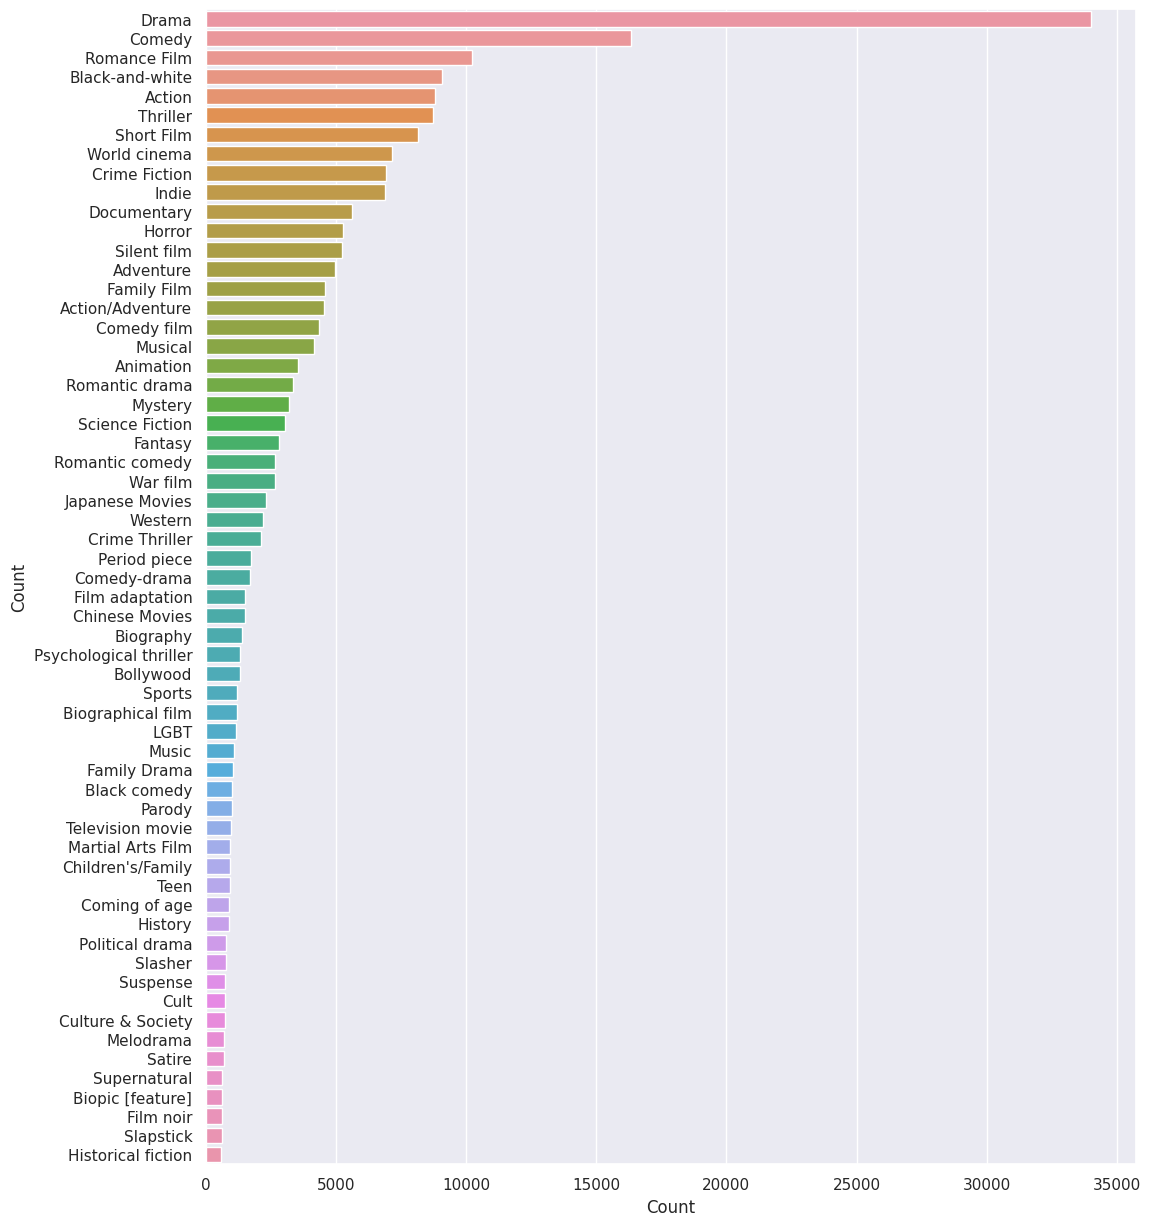

In [54]:
# Plot the top 60 genders of filmes
plot = todos_generos.nlargest(columns='Count',n=60)
plt.figure(figsize=(12,15))
ax = sns.barplot(data=plot, x= 'Count', y='Genero')
ax.set(ylabel = 'Count')
plt.show()

### 3.1.2 WordCloud Genres Analysis

In [55]:
df4.head()

,id_filme,nome_filme,genero_filme,sinopse_filme
0,975900,Ghosts of Mars,"[Thriller, Science Fiction, Horror, Adventure,...","Set in the second half of the 22nd century, th..."
3,9363483,White Of The Eye,"[Thriller, Erotic thriller, Psychological thri...",A series of murders of rich young women throug...
4,261236,A Woman in Flames,[Drama],"Eva, an upper class housewife, becomes frustra..."
6,18998739,The Sorcerer's Apprentice,"[Family Film, Fantasy, Adventure, World cinema]","Every hundred years, the evil Morgana returns..."
12,6631279,Little city,"[Romantic comedy, Ensemble Film, Comedy-drama,...","Adam, a San Francisco-based artist who works a..."


In [56]:
df_aux = df4.copy()
# Transform genres from list to string so we can add them into a wordcloud
df_aux['genero_filme'] = df_aux['genero_filme'].apply(lambda x: ','.join(x))

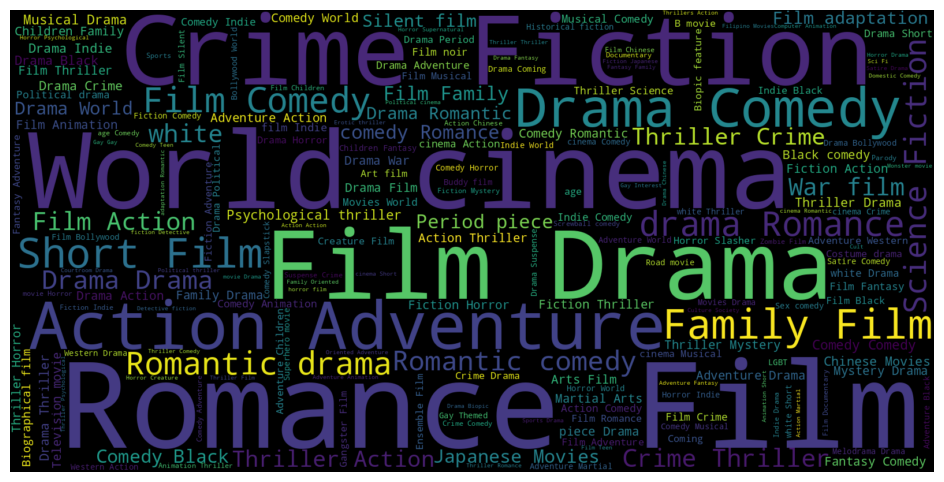

In [57]:
text = " ".join(i for i in df_aux['genero_filme'])
stopwords = set(STOPWORDS)
stopwords.update([',','.'])
wordcloud = WordCloud(stopwords=stopwords,background_color='black',width=1600,height=800).generate(text)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()


### 3.1.3 Number of Genders per Sinopse

In [58]:
df_aux['number_generos'] = df_aux['genero_filme'].apply(lambda x: len(x.split(',')))

In [59]:
df_aux.head()

,id_filme,nome_filme,genero_filme,sinopse_filme,number_generos
0,975900,Ghosts of Mars,"Thriller,Science Fiction,Horror,Adventure,Supe...","Set in the second half of the 22nd century, th...",7
3,9363483,White Of The Eye,"Thriller,Erotic thriller,Psychological thriller",A series of murders of rich young women throug...,3
4,261236,A Woman in Flames,Drama,"Eva, an upper class housewife, becomes frustra...",1
6,18998739,The Sorcerer's Apprentice,"Family Film,Fantasy,Adventure,World cinema","Every hundred years, the evil Morgana returns...",4
12,6631279,Little city,"Romantic comedy,Ensemble Film,Comedy-drama,Dra...","Adam, a San Francisco-based artist who works a...",7


In [60]:
print('Max number of genres per synopsis: {}'.format(max(df_aux['number_generos'])))
print('Min number of genres per synopsis: {}'.format(min(df_aux['number_generos'])))
print('Average number of genres per synopsis: {:.2f}'.format(sum(df_aux['number_generos']) / len(df_aux['number_generos'])))


Max number of genres per synopsis: 17
Min number of genres per synopsis: 1
Average number of genres per synopsis: 3.61


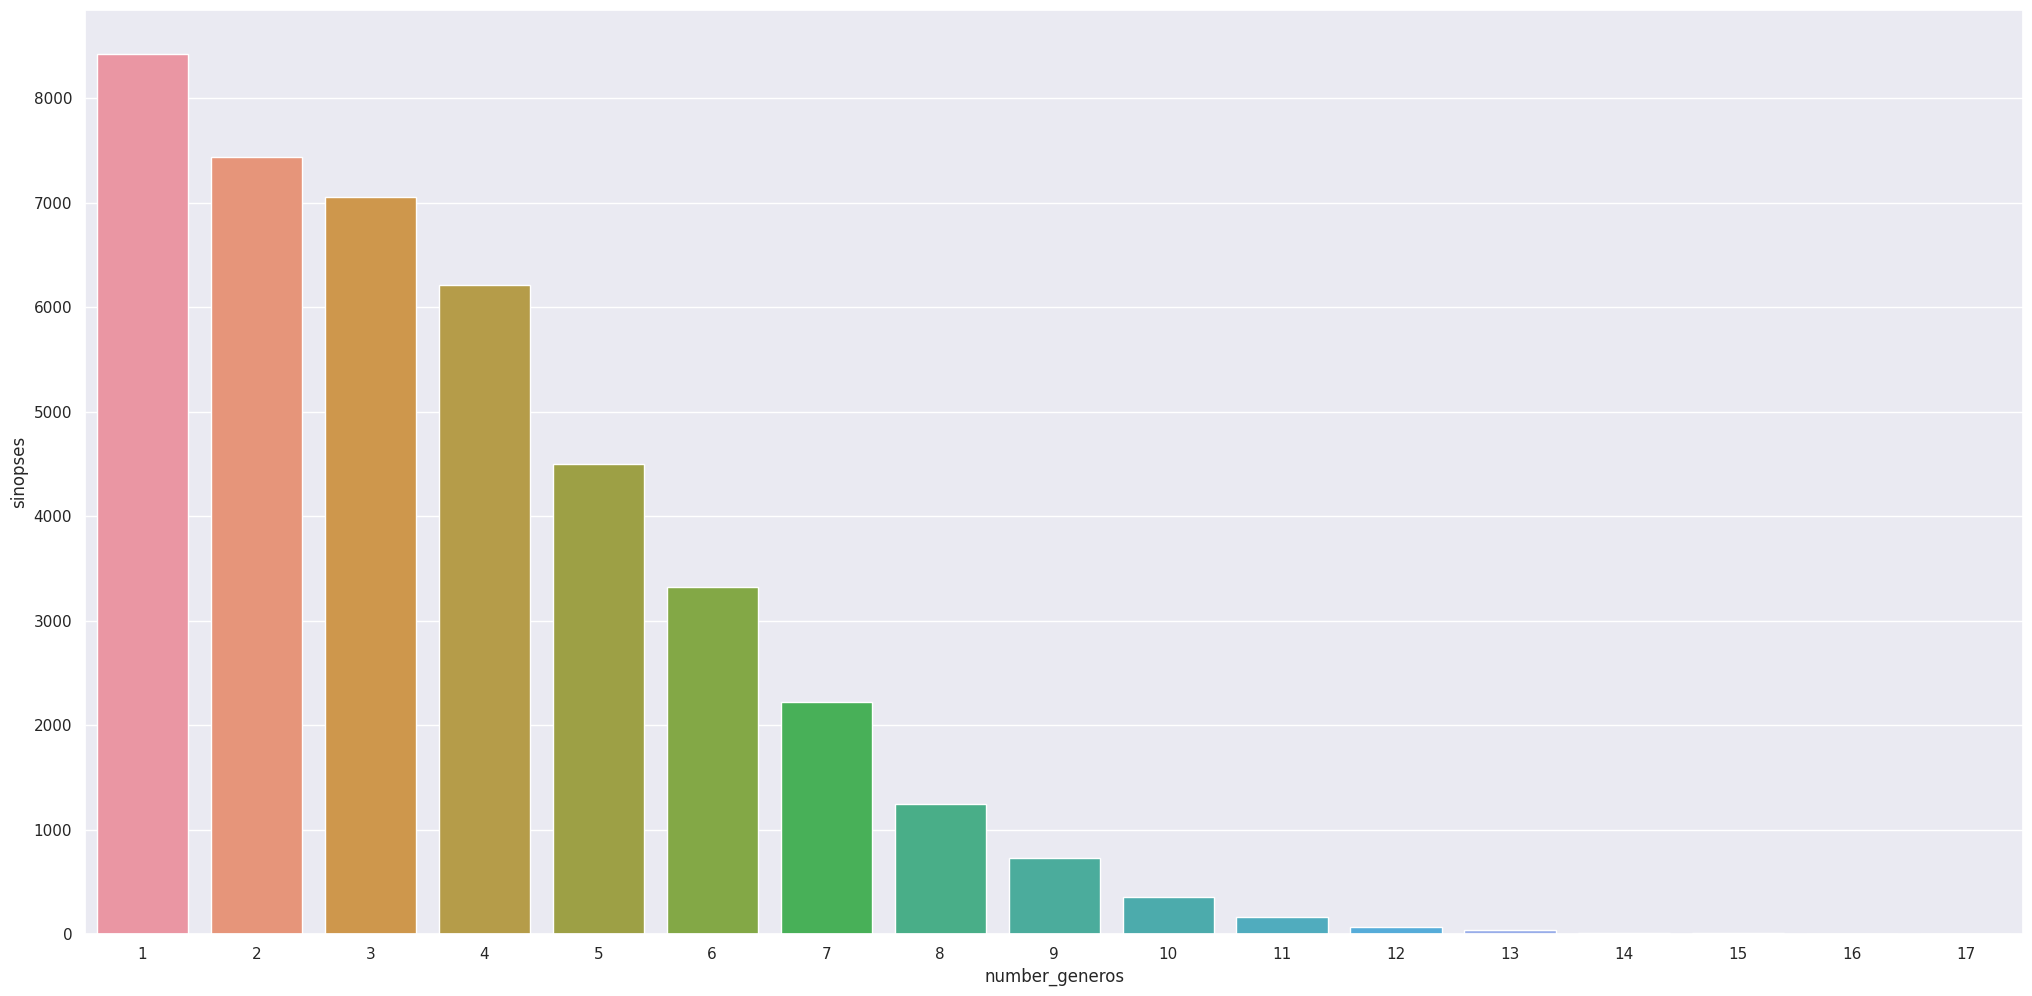

In [61]:
df_aux_2 = df_aux[['id_filme','number_generos']].groupby('number_generos').count().reset_index().rename(columns={'id_filme':'sinopses'})
df_aux_2 = df_aux_2.sort_values('sinopses',ascending=False)
sns.barplot(x='number_generos',y='sinopses',data=df_aux_2);

## 3.2 Variable Text - Sinopse

Lets first do a quicly cleaning on the column sinopse_filme

In [62]:
df4['sinopse_filme'].head(10)

0     Set in the second half of the 22nd century, th...
3     A series of murders of rich young women throug...
4     Eva, an upper class housewife, becomes frustra...
6     Every hundred years, the evil Morgana  returns...
12    Adam, a San Francisco-based artist who works a...
13    {{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...
14    Serap, a young actress with a strong, lively p...
15     The story starts as one of the robots flies i...
17    The film opens with Mary Poppins  perched in a...
22    Jimmy ([[Hiroshi Watanabe  loves dinosaurs and...
Name: sinopse_filme, dtype: object

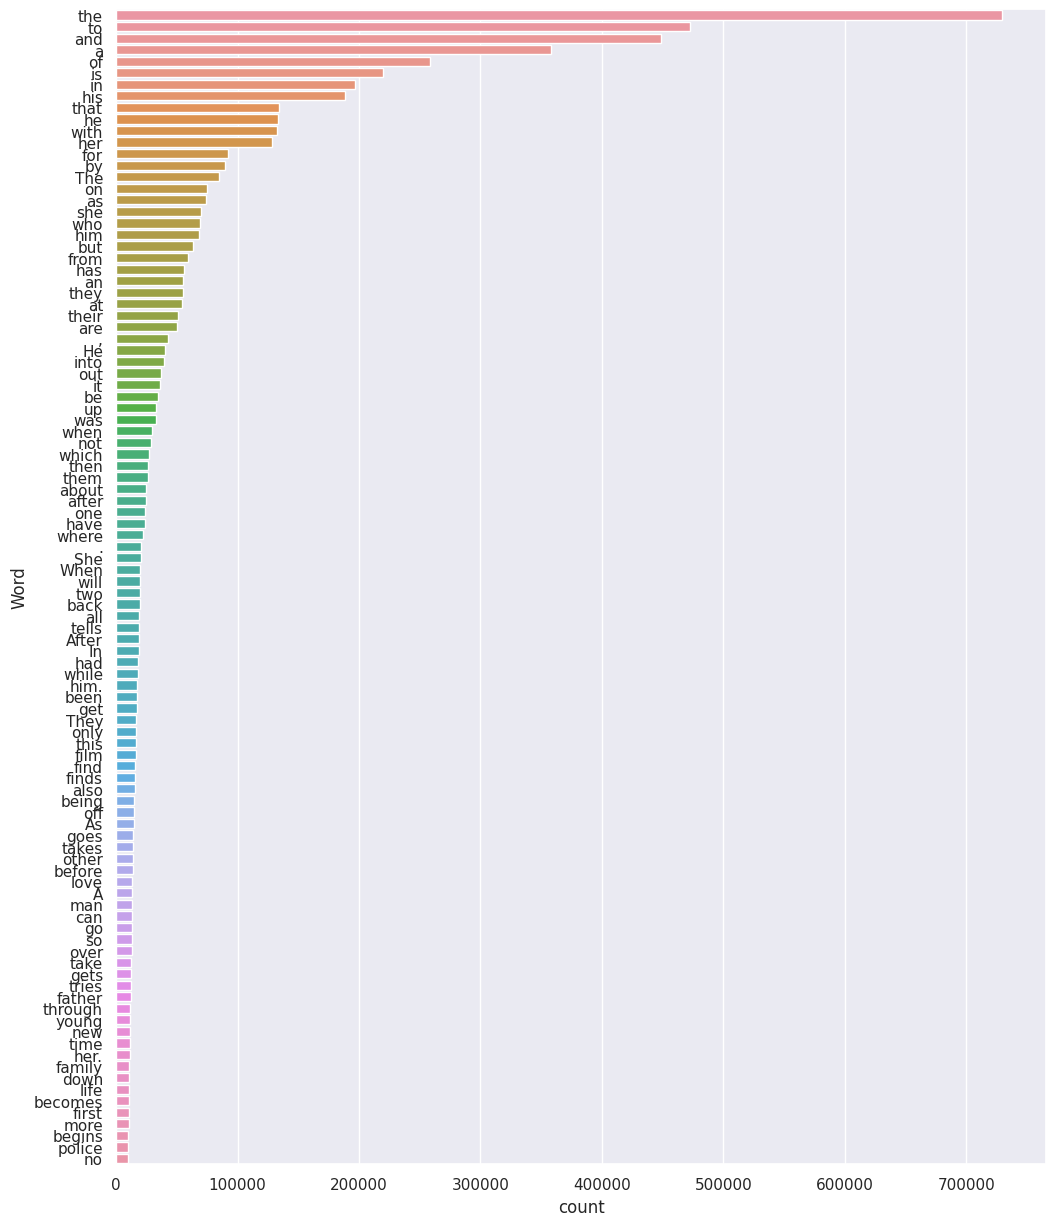

In [63]:
def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x]) 
    all_words = all_words.split()
    fdist = nltk.FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
    
    # selecting top 20 most frequent words 
    d = words_df.nlargest(columns="count", n = terms) 

    # visualize words and frequencies
    plt.figure(figsize=(12,15)) 
    ax = sns.barplot(data=d, x= "count", y = "word") 
    ax.set(ylabel = 'Word') 
    plt.show()
    
# print 100 most frequent words 
freq_words(df4['sinopse_filme'], 100)

As shown in the charts above, a large portion of the terms are identified as stopwords. Stopwords are typically common words in a language that are frequently removed from texts before they are processed for tasks such as natural language processing, text classification or information retrieval.

Since stopwords are less informative than other keywords present in the texts, they can add unnecessary noise to our model. In the next section, we will use some preprocessing techniques to clean up our data.

# 4.0 Data Preparation - PreProcessing and Cleaning

In [64]:
df5 = df4.copy()

Pre-Processing Inital Cleaning Process:
* Lower Case
* Remove Contraction to Expansion
* Removal of Special Chars
* Removal of Accented Chars
* Removal of duplicated empty spaces
* Removal of stopwords


In [65]:
df5.head()

,id_filme,nome_filme,genero_filme,sinopse_filme
0,975900,Ghosts of Mars,"[Thriller, Science Fiction, Horror, Adventure,...","Set in the second half of the 22nd century, th..."
3,9363483,White Of The Eye,"[Thriller, Erotic thriller, Psychological thri...",A series of murders of rich young women throug...
4,261236,A Woman in Flames,[Drama],"Eva, an upper class housewife, becomes frustra..."
6,18998739,The Sorcerer's Apprentice,"[Family Film, Fantasy, Adventure, World cinema]","Every hundred years, the evil Morgana returns..."
12,6631279,Little city,"[Romantic comedy, Ensemble Film, Comedy-drama,...","Adam, a San Francisco-based artist who works a..."


In [66]:
with open('../data/contractions.txt') as file:
    data = file.read()

contractions = json.loads(data)

# Cleaning Sinopse Text
df5['sinopse_filme'] = df5['sinopse_filme'].apply(lambda x:clean_text(x))


In [67]:
df5['sinopse_filme'].head(5)

0     set second half nd century film depicts mars p...
3     series murders rich young women throughout ari...
4     eva upper class housewife becomes frustrated l...
6     every hundred years evil morgana returns claim...
12    adam san francisco based artist works cab driv...
Name: sinopse_filme, dtype: object

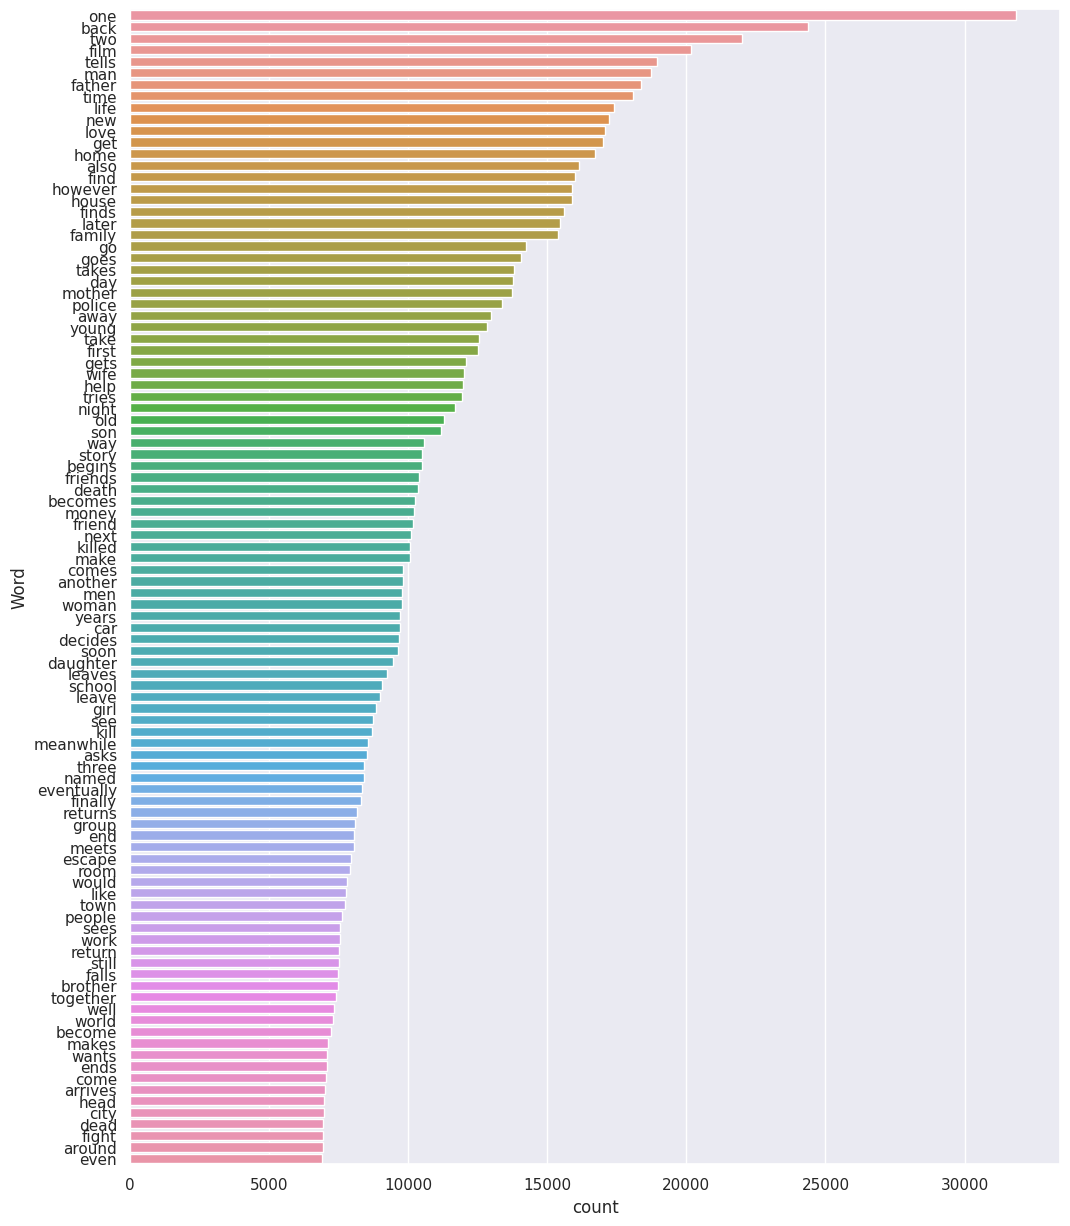

In [68]:
freq_words(df5['sinopse_filme'], 100)

Comparing this latest graph with the previous one plotted in the last section, we can observe that with data preprocessing and cleaning, the most frequent words in our data start to make more sense, and at the same time, we can see that we have some words that repeat a lot and can simultaneously add a lot of information such as "war," "love," "death," "police," and others.

# 5.0 Feature Creation

We will be focusing on the TF-IDF technique in this project to convert our train and test dataset into numerical vectors.

* The TF-IDF technique is a widely used text mining approach that aims to measure the relevance of a term in a document or corpus.
* It stands for Term Frequency-Inverse Document Frequency and consists of two parts: the term frequency (TF), which measures how frequently a term appears in a document, and the inverse document frequency (IDF), which measures how important a term is across the entire corpus.
* The TF-IDF score is the product of these two measures, where a high score indicates that a term is both frequent in a document and rare across the corpus, making it more relevant to the document

In [69]:
df6 = df5.copy()

In [70]:
df6.head()

,id_filme,nome_filme,genero_filme,sinopse_filme
0,975900,Ghosts of Mars,"[Thriller, Science Fiction, Horror, Adventure,...",set second half nd century film depicts mars p...
3,9363483,White Of The Eye,"[Thriller, Erotic thriller, Psychological thri...",series murders rich young women throughout ari...
4,261236,A Woman in Flames,[Drama],eva upper class housewife becomes frustrated l...
6,18998739,The Sorcerer's Apprentice,"[Family Film, Fantasy, Adventure, World cinema]",every hundred years evil morgana returns claim...
12,6631279,Little city,"[Romantic comedy, Ensemble Film, Comedy-drama,...",adam san francisco based artist works cab driv...


## 5.1 Split Train and Validation Dataset

In [71]:
x_train, x_validation, y_train, y_validation = train_test_split(df6['sinopse_filme'], y, test_size=0.2, random_state=42)

Here we will change a bit and define de max_df paremeter of tfidf as 0.8. That means that we will ignore the therms that appear in more than 85% of the synopsis. Later we will do another test with other parameters as well

In [72]:
# Create the Matrix of tdidf frequency of words
tfidf = TfidfVectorizer(analyzer='word',stop_words='english',max_features=10000,max_df=0.8)
X = tfidf.fit_transform(df6['sinopse_filme'])

In [73]:
X

<41793x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 3947163 stored elements in Compressed Sparse Row format>

Here we have, 41793 rows with 10.000 features or words (each value of this matrix represents the tdidf frequency of a word

In [74]:
y.shape

(41793, 363)

Lets take a look at the vocabulary selected from the Vectorier to check what are the count of the top words selected for our model

In [75]:
tfidf.get_feature_names_out()

array(['aakash', 'aaron', 'aarti', ..., 'zoo', 'zooms', 'zorro'],
      dtype=object)

As we can see, we made a initial cleaning in the dataset, so now lets test some models

## 5.2 Apply Tfidf Transformation 

Applying tfidf Vectorizer into the training and validation dataset

In [76]:
x_train = tfidf.transform(x_train)
x_validation = tfidf.transform(x_validation)

# 6.0 Model Testing

## 6.1 Machine Learning Modelling

### 6.1.1 SGD

In [77]:
sgd = SGDClassifier()
clf_sgd = OneVsRestClassifier(sgd,n_jobs=-1)

clf_sgd.fit(x_train,y_train)
y_pred = clf_sgd.predict(x_validation)

print('OneVsRestaClassifier: Estimator SGD')
multilabel_metrics(clf_sgd,y_validation,y_pred)



/home/jordanmalheiros/Estudismo/venvs/venv-projectNLP/.venv/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 56 is present in all training examples.
  warnings.warn(
/home/jordanmalheiros/Estudismo/venvs/venv-projectNLP/.venv/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 66 is present in all training examples.
  warnings.warn(
/home/jordanmalheiros/Estudismo/venvs/venv-projectNLP/.venv/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 202 is present in all training examples.
  warnings.warn(
/home/jordanmalheiros/Estudismo/venvs/venv-projectNLP/.venv/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 214 is present in all training examples.
  warnings.warn(


OneVsRestaClassifier: Estimator SGD


,Model Name,accuracy,precision,recall,f1_score,hamming_loss,jaccard_score
0,OneVsRestClassifier,0.0711,0.8557,0.1502,0.1894,0.0090,0.1281


### 6.1.2 LogisticRegression()

In [78]:
lr = LogisticRegression()
clf_lr = OneVsRestClassifier(lr,n_jobs=-1)

clf_lr.fit(x_train,y_train)
y_pred = clf_lr.predict(x_validation)

print('OneVsRestaClassifier: Estimator LogisticRegression')
multilabel_metrics(clf_lr,y_validation,y_pred)



/home/jordanmalheiros/Estudismo/venvs/venv-projectNLP/.venv/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 56 is present in all training examples.
  warnings.warn(
/home/jordanmalheiros/Estudismo/venvs/venv-projectNLP/.venv/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 66 is present in all training examples.
  warnings.warn(
/home/jordanmalheiros/Estudismo/venvs/venv-projectNLP/.venv/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 202 is present in all training examples.
  warnings.warn(
/home/jordanmalheiros/Estudismo/venvs/venv-projectNLP/.venv/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 214 is present in all training examples.
  warnings.warn(


OneVsRestaClassifier: Estimator LogisticRegression


,Model Name,accuracy,precision,recall,f1_score,hamming_loss,jaccard_score
0,OneVsRestClassifier,0.0733,0.7280,0.1978,0.2556,0.0088,0.1697


### 6.1.3 Linear SVC


In [79]:
svc = LinearSVC()
clf_svc = OneVsRestClassifier(svc,n_jobs=-1)

clf_svc.fit(x_train,y_train)
y_pred = clf_svc.predict(x_validation)

print('OneVsRestaClassifier: Estimator LogisticRegression')
multilabel_metrics(clf_svc,y_validation,y_pred)

/home/jordanmalheiros/Estudismo/venvs/venv-projectNLP/.venv/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 56 is present in all training examples.
  warnings.warn(
/home/jordanmalheiros/Estudismo/venvs/venv-projectNLP/.venv/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 66 is present in all training examples.
  warnings.warn(
/home/jordanmalheiros/Estudismo/venvs/venv-projectNLP/.venv/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 202 is present in all training examples.
  warnings.warn(
/home/jordanmalheiros/Estudismo/venvs/venv-projectNLP/.venv/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 214 is present in all training examples.
  warnings.warn(


OneVsRestaClassifier: Estimator LogisticRegression


,Model Name,accuracy,precision,recall,f1_score,hamming_loss,jaccard_score
0,OneVsRestClassifier,0.0642,0.5747,0.2888,0.3442,0.0091,0.2300


We observed a slight improvement in our performance after applying some preprocessing and cleaning techniques. However, it's not ideal. In the next cycle, we will experiment different parameters for the models (fine-tuning / balanced params), change the way the TFIDF is creating our features, and normalize our data to achieve faster convergence on the algorithms

Although we haven't improved our model performance that much, I will define a baseline model to make predictions on some synopses and see how the defined labels are behaving.





# 7.0 Hyperparameter Fine Tuning

# 8.0 Final Model

## 8.1 Join Train and Validation Dataset

In [80]:
x_train_final = X
y_train_final = y

## 8.2 Baseline Model - LinearSVC

In [81]:
svc = LinearSVC()
clf_svc = OneVsRestClassifier(svc,n_jobs=-1)
clf_svc.fit(x_train_final,y_train_final)


OneVsRestClassifier(estimator=LinearSVC(), n_jobs=-1)

# 9.0 Predict Movie Genres

In [82]:
print('Enter the sinopse:')
sinopse = input()
print('\n')
# print(sinopse)

Enter the sinopse:


 In 1936, archaeologist Indiana Jones braves an ancient Peruvian temple filled with booby traps to retrieve a golden idol. Upon fleeing the temple, Indiana is confronted by rival archaeologist René Belloq and the indigenous Hovitos. Surrounded and outnumbered, Indiana is forced to surrender the idol to Belloq and escapes aboard a waiting Waco seaplane, in the process revealing his fear of snakes. Shortly after returning to the college in the United States where he teaches archaeology, Indiana is interviewed by two Army intelligence agents. They inform him that the Nazis, in their quest for occult power, are searching for his old mentor, Abner Ravenwood, who is the leading expert on the ancient Egyptian city of Tanis and possesses the headpiece of an artifact called the Staff of Ra. Indiana deduces that the Nazis are searching for Tanis because it is believed to be the location of the Ark of the Covenant, the biblical chest built by the Israelites to contain the fragments of the Ten Com

In [83]:
predict_genres(clf_svc,sinopse)

[('Action', 'Adventure', 'Costume Adventure')]

# 10. Model to Production